<a href="https://colab.research.google.com/github/rihabsghaier/Signature_verification/blob/master/ch%C3%A9que.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the necessary packages
import numpy as np
import cv2
from skimage.filters import threshold_local
import imutils
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect


In [0]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

STEP 1: Edge Detection


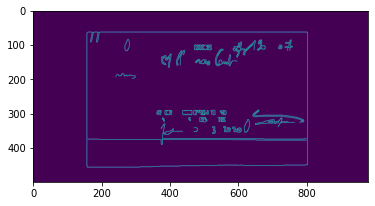

In [0]:
import imutils
import matplotlib.pyplot as plt

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("/content/Sans titre.png")
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
plt.imshow( image)
plt.imshow( edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

STEP 2: Find contours of paper


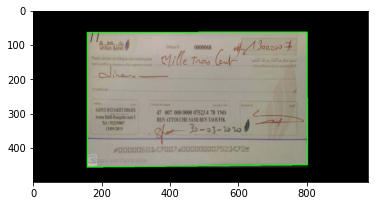

In [0]:
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
#screenCnt=cnts
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
	
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow( image)
cv2.waitKey(0)
cv2.destroyAllWindows()

STEP 3: Apply perspective transform


-1

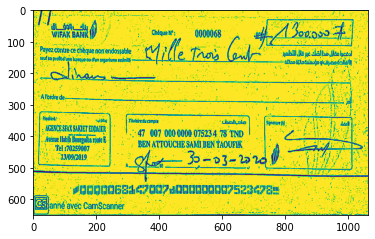

In [0]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 1, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
# show the original and scanned images
print("STEP 3: Apply perspective transform")
plt.imshow( imutils.resize(orig, height = 650))
plt.imshow( imutils.resize(warped, height = 650))
cv2.waitKey(0)

the_biggest_component: 12543
average: 161.24302325581397
a4_constant: 869.8349252491696


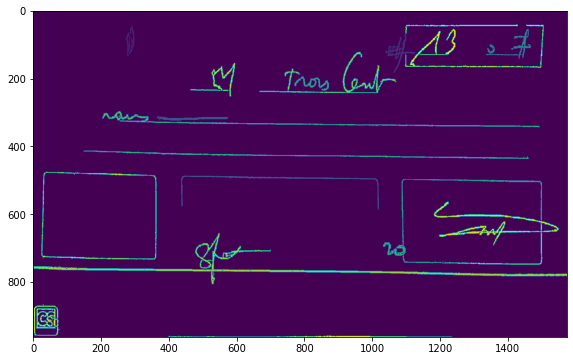

In [0]:
import cv2
import matplotlib.pyplot as plt
from skimage import measure, morphology
# from skimage.color import label2rgb
from skimage.measure import regionprops


"""Extract signature from an input image.

   Parameters
    ----------
    source_image : numpy ndarray
        The pinut image.

    Returns
    -------
    numpy ndarray
        An image with the extracted signatures.

    """
    # read the input image
    
img = cv2.threshold(warped, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary

    # connected component analysis by scikit-learn framework
blobs = img > img.mean()
blobs_labels = measure.label(blobs, background=1)
    # image_label_overlay = label2rgb(blobs_labels, image=img)

fig, ax = plt.subplots(figsize=(10, 6))

'''
    # plot the connected components (for debugging)
    ax.imshow(image_label_overlay)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    '''

the_biggest_component = 0
total_area = 0
counter = 0
average = 0.0
for region in regionprops(blobs_labels):
  if (region.area > 10):
    total_area = total_area + region.area
    counter = counter + 1
    #print region.area 
# (for debugging)
# take regions with large enough areas
  if (region.area >= 250):
    if (region.area > the_biggest_component):
      the_biggest_component = region.area
average = (total_area/counter)
print("the_biggest_component: " + str(the_biggest_component))
print("average: " + str(average))

    # experimental-based ratio calculation, modify it for your cases
    # a4_constant is used as a threshold value to remove connected pixels
    # are smaller than a4_constant for A4 size scanned documents
a4_constant = (((average/84.0)*250.0)+100)*1.5  #84.0  250.0  1.5
print("a4_constant: " + str(a4_constant))

    # remove the connected pixels are smaller than a4_constant
b = morphology.remove_small_objects(blobs_labels, a4_constant)
    # save the the pre-version which is the image is labelled with colors
    # as considering connected components
b =b.astype(np.uint8)
plt.imsave('pre_version.png',b)
plt.imshow(b)

    # read the pre-version
img = cv2.imread('a.png', 0)
    # ensure binary

img = cv2.threshold(img, 0, 255,
                        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # save the the result
    # cv2.imwrite("output.png", img)
#return img
#plt.imshow(img)

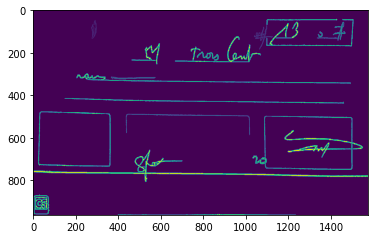

In [0]:
import cv2
import matplotlib.pyplot as plt



"""Soften an input image.

    Parameters
    ----------
    image : numpy ndarray
        The input image.

    Returns
    -------
    numpy ndarray
        The soften image.

    """
    # perform GaussianBlur filter to use it in unsharpening mask

gaussian_3 = cv2.GaussianBlur(b, (9,9),10)
    # calculates the weighted sum of two arrays (source image and GaussianBlur
    # filter) to perform unsharpening mask
unsharp_image = cv2.addWeighted(b, 1.5, gaussian_3, -0.5, 0, img)
    # return unsharpened image
plt.imshow(unsharp_image)


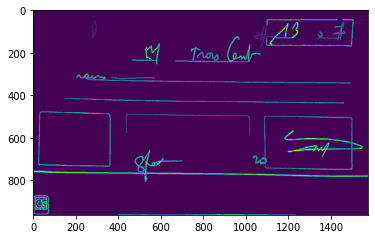

In [0]:
import cv2

contrast = 0
brightness = 0
#def funcBrightContrast(img, bright=0):
"""Adjust the image contrast/brightness.

    Parameters
    ----------
    img : numpy ndarray
        The input image.
    bright : int
        The brightness level.

    Returns
    -------
    numpy ndarray
        The image whose brightness/contrast is adjusted.

    """
#effect = apply_brightness_contrast(b, bright, contrast)
    # save the final output image
    # cv2.imwrite("./outputs/" + output_img, effect)
#return effect
#plt.imshow(effect)


#def apply_brightness_contrast(input_img, brightness=255, contrast=127):
"""Perform the color correction of an input image.

    Parameters
    ----------
    input_img : numpy ndarray
        The input image.
    brightness : int
        the brightness level.
    contrast : int
        the contrast level.

    Returns
    -------
    numpy ndarray
        The image whose brightness is adjusted .

    """
brightness = 0
contrast = 0

    # if brightness is not equal to 0
if (brightness != 0):
  if (brightness > 0):
    shadow = brightness
    highlight = 255
  else:
    shadow = 0
    highlight = 255 + brightness
        # calculating the alpha value
  alpha_b = (highlight - shadow) / 255
        # set the gamma value
  gamma_b = shadow
        # to change the brightness in order to use the cv2.addWeighted()
  buf = cv2.addWeighted(b, alpha_b, b, 0, gamma_b)
else:
  buf = b.copy()
    # if contrast does not equal 0
if contrast != 0:
  f = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        # calculating the alpha value
  alpha_c = f
        # set the gamma value
  gamma_c = 127*(1-f)
        # to change the contrast in order to use the cv2.addWeighted()
  buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
plt.imshow(buf)
    # return color corrected image
    #return buf
